In [2]:
# Fonction pour ouvrir l'image à partir de son chemin d'accès
from PIL import Image

# Librairies classiques
import pandas as pd
import numpy as np
import sys
import os
import io
import time
import glob
path_local = 'dataSample/*/'

In [3]:
os.environ['PYSPARK_PYTHON'] = sys.executable

In [4]:
print('PYSPARK_PYTHON ', os.environ['PYSPARK_PYTHON'])

PYSPARK_PYTHON  /home/soumaya/anaconda3/envs/openclassrooms/bin/python


In [5]:
os.environ['PYSPARK_DRIVER_PYTHON'] ='/home/soumaya/anaconda3/envs/openclassrooms/bin/python'

In [6]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema

In [7]:
def init_spark_session(path_local=''):
    '''Initie une session SPARK avec stockage local pour le moment
    :return SparkContext'''

    path_img = path_local

    # Instantiation d'une SparkSession et d'un Spark Context  
    spark = SparkSession.builder.master('local[*]').appName('P8').getOrCreate()
    sc = spark.sparkContext

    return sc, spark, path_img


In [8]:
sc, spark, path_img = init_spark_session(path_local = path_local)


In [9]:
path_img

'dataSample/*/'

In [9]:
spark

In [11]:
import pyspark
from pyspark import SQLContext
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType, col
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [12]:
#charger les images sous format "binaire"

df_img_binary = spark.read.format("binaryFile")\
               .option("pathGlobFilter", "*.jpg") \
               .option("recursiveFileLookup", "true")\
               .load(path_img)

In [20]:
lien_img_1 = df_img_binary.collect()[0]['content']
lien_img_1

bytearray(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00d\x00d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\

In [31]:
str= df_img_binary.collect()[0]['path']
str

'file:/home/soumaya/Documents/formationOpenclassrooms/deploy_cloud_model/dataSample/Apricot/11_100.jpg'

In [42]:
image = Image.open(io.BytesIO(b'dataSample/Apricot/11_100.jpg'))

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f0d392b6b80>

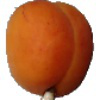

In [44]:
byteImgIO = io.BytesIO()
byteImg = Image.open('dataSample/Apricot/11_100.jpg')
byteImg.save(byteImgIO, "png")
byteImgIO.seek(0)
byteImg = byteImgIO.read()


# Non test code
dataBytesIO = io.BytesIO(byteImg)
Image.open(dataBytesIO)

#image = Image.open(io.BytesIO(b'file:/home/soumaya/Documents/formationOpenclassrooms/deploy_cloud_model/dataSample/Apricot/11_100.jpg'))

In [12]:
# charger les images sous format "image"
#df_imgtype = spark.read.format("image")\
#            .option("pathGlobFilter", "*.jpg") \
#            .option("recursiveFileLookup", "true")\
#            .load(path_img)

(100, 100, 3)


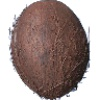

In [13]:
#affichage d'une image en ytilisant la format "image"
#import numpy as np
#a = df_imgtype.first()
#b = np.array(a.asDict()['image']['data']).reshape(100,100,3)[:,:,::-1]
#print(b.shape)
#Image.fromarray(b, 'RGB')

In [45]:
# créer le modèle de transfer learning ResNet50

model = ResNet50(include_top=False)
bc_model_weights = sc.broadcast(model.get_weights())
model.set_weights(bc_model_weights.value)

In [15]:
# pretraitement des images (type et taille)

def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content))
    #img = img.convert('RGB')
    img = img.resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

In [16]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))   
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [17]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [18]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [19]:
# We can now run featurization on our entire Spark DataFrame.
features_df = df_img_binary.repartition(16).select(col("path"), featurize_udf("content").alias("features"))

INFO:tensorflow:Assets written to: ram://ba73ba86-abdc-4c08-b412-ceb810b5c8d4/assets


/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Réduction des dimensions des features

In [20]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.linalg import Vectors, VectorUDT

In [21]:
# Les données images sont converties au format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
features_df = features_df.withColumn('vector_features', ud_f('features'))

In [22]:
# standardisation des features
scaler = StandardScaler(
    inputCol = 'vector_features', 
    outputCol = 'scaledFeatures')

In [23]:
df_scaled = scaler.fit(features_df).transform(features_df)

In [ ]:
# entrainement de l'algorithme
pca = PCA(k=2,inputCol='scaledFeatures', outputCol='pcaFeatures')
print ("ok")
pcaModel = pca.fit(df_scaled)

ok


In [ ]:
# Calcul de la variance expliquée cumulée par les composantes
cumValues = pcaModel.explainedVariance.cumsum() # get the cumulative values

# afficher le graphe pour décider du nombre de composantes à considérer
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(range(1,3), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')


In [ ]:
# Transformation des images sur les k (k=2) premières composantes
df_pca = pcaModel.transform(df_scaled)
df_pca = df_pca.filter(df_pca.pcaFeatures.isNotNull())

In [ ]:
# sauvegarder les features sous format parquet
df_pca.write.mode("overwrite").parquet("extracted_features/fruits_features")